### Подключение библиотек и настройка изображений

In [1]:
!pip install pyspark

In [2]:
import numpy as np
import pandas as pd

import matplotlib as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, countDistinct, count, size, when, regexp_extract, split

sns.set_style("darkgrid")
params = {"legend.fontsize" : "medium", "figure.figsize" : (10, 8), "figure.dpi" : 100, "axes.labelsize" : "medium", "axes.titlesize" : "medium", "xtick.labelsize": "medium", "ytick.labelsize" : "medium"}

plt.rcParams.update(params)

### Запуск сессии Pyspark

In [3]:
spark = SparkSession.builder.appName("EDA Films").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/15 18:58:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Загрузка и обзор датасета

In [4]:
df_movies = spark.read.csv("sp_movies.csv", header=True, inferSchema=True)
df_ratings = spark.read.csv("sp_ratings.csv", header=True, inferSchema=True)
df_tags = spark.read.csv("sp_tags.csv", header=True, inferSchema=True)

In [5]:
df_movies.show(3)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
+-------+--------------------+--------------------+
only showing top 3 rows



In [6]:
df_ratings.show(3)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
+------+-------+------+---------+
only showing top 3 rows



In [7]:
df_tags.show(3)

+------+-------+---------------+----------+
|userId|movieId|            tag| timestamp|
+------+-------+---------------+----------+
|     2|  60756|          funny|1445714994|
|     2|  60756|Highly quotable|1445714996|
|     2|  60756|   will ferrell|1445714992|
+------+-------+---------------+----------+
only showing top 3 rows



### Статистика данных

#### Количество пользователей поставивших оценку

In [8]:
df_ratings.select(countDistinct("userId")).show()

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                   610|
+----------------------+



#### Количество оценненых фильмов

In [9]:
df_ratings.select(countDistinct("movieId")).show()

+-----------------------+
|count(DISTINCT movieId)|
+-----------------------+
|                   9724|
+-----------------------+



#### Количество комментариев к фильмам

In [10]:
df_tags.select(countDistinct("movieId")).show()

+-----------------------+
|count(DISTINCT movieId)|
+-----------------------+
|                   1572|
+-----------------------+



### Предобработка и настройка данных

In [11]:
df1 = df_ratings.alias("df1")
df2 = df_tags.alias("df2")
df3 = df_movies.alias("df3")

In [12]:
df3.show(20)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
|      6|         Heat (1995)|Action|Crime|Thri...|
|      7|      Sabrina (1995)|      Comedy|Romance|
|      8| Tom and Huck (1995)|  Adventure|Children|
|      9| Sudden Death (1995)|              Action|
|     10|    GoldenEye (1995)|Action|Adventure|...|
|     11|American Presiden...|Comedy|Drama|Romance|
|     12|Dracula: Dead and...|       Comedy|Horror|
|     13|        Balto (1995)|Adventure|Animati...|
|     14|        Nixon (1995)|               Drama|
|     15|Cutthroat Island ...|Action|Adventure|...|
|     16|       Casino (1995)|         Crime|Drama|
|     17|Sen

In [13]:
df3 = df3.withColumn("year", regexp_extract(df3["title"], r"\((\d{4})\)", 1))

In [14]:
df3.show()

+-------+--------------------+--------------------+----+
|movieId|               title|              genres|year|
+-------+--------------------+--------------------+----+
|      1|    Toy Story (1995)|Adventure|Animati...|1995|
|      2|      Jumanji (1995)|Adventure|Childre...|1995|
|      3|Grumpier Old Men ...|      Comedy|Romance|1995|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|1995|
|      5|Father of the Bri...|              Comedy|1995|
|      6|         Heat (1995)|Action|Crime|Thri...|1995|
|      7|      Sabrina (1995)|      Comedy|Romance|1995|
|      8| Tom and Huck (1995)|  Adventure|Children|1995|
|      9| Sudden Death (1995)|              Action|1995|
|     10|    GoldenEye (1995)|Action|Adventure|...|1995|
|     11|American Presiden...|Comedy|Drama|Romance|1995|
|     12|Dracula: Dead and...|       Comedy|Horror|1995|
|     13|        Balto (1995)|Adventure|Animati...|1995|
|     14|        Nixon (1995)|               Drama|1995|
|     15|Cutthroat Island ...|A

### Извлечение данных о жанрах

In [15]:
split_expr = split(df3["genres"], "\\|")
for i in range(1,11):
    df3 = df3.withColumn("genre{}".format(i), split_expr.getItem(i-1))


In [16]:
df3.show()

+-------+--------------------+--------------------+----+---------+---------+--------+------+--------+------+------+------+------+-------+
|movieId|               title|              genres|year|   genre1|   genre2|  genre3|genre4|  genre5|genre6|genre7|genre8|genre9|genre10|
+-------+--------------------+--------------------+----+---------+---------+--------+------+--------+------+------+------+------+-------+
|      1|    Toy Story (1995)|Adventure|Animati...|1995|Adventure|Animation|Children|Comedy| Fantasy|  NULL|  NULL|  NULL|  NULL|   NULL|
|      2|      Jumanji (1995)|Adventure|Childre...|1995|Adventure| Children| Fantasy|  NULL|    NULL|  NULL|  NULL|  NULL|  NULL|   NULL|
|      3|Grumpier Old Men ...|      Comedy|Romance|1995|   Comedy|  Romance|    NULL|  NULL|    NULL|  NULL|  NULL|  NULL|  NULL|   NULL|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|1995|   Comedy|    Drama| Romance|  NULL|    NULL|  NULL|  NULL|  NULL|  NULL|   NULL|
|      5|Father of the Bri...|    

In [17]:
genre_columns = ["genre{}".format(i) for i in range(1, 11)]
for col_name in genre_columns:
    df3 = df3.withColumn(col_name, col(col_name).cast("string").alias(col_name))

genre_count_expr = sum(when(col(col_name) != "0", 1).otherwise(0) for col_name in genre_columns)
df3 = df3.withColumn("genre_count", genre_count_expr)

In [18]:
df3 = df3.drop("genres")
df3.show()

+-------+--------------------+----+---------+---------+--------+------+--------+------+------+------+------+-------+-----------+
|movieId|               title|year|   genre1|   genre2|  genre3|genre4|  genre5|genre6|genre7|genre8|genre9|genre10|genre_count|
+-------+--------------------+----+---------+---------+--------+------+--------+------+------+------+------+-------+-----------+
|      1|    Toy Story (1995)|1995|Adventure|Animation|Children|Comedy| Fantasy|  NULL|  NULL|  NULL|  NULL|   NULL|          5|
|      2|      Jumanji (1995)|1995|Adventure| Children| Fantasy|  NULL|    NULL|  NULL|  NULL|  NULL|  NULL|   NULL|          3|
|      3|Grumpier Old Men ...|1995|   Comedy|  Romance|    NULL|  NULL|    NULL|  NULL|  NULL|  NULL|  NULL|   NULL|          2|
|      4|Waiting to Exhale...|1995|   Comedy|    Drama| Romance|  NULL|    NULL|  NULL|  NULL|  NULL|  NULL|   NULL|          3|
|      5|Father of the Bri...|1995|   Comedy|     NULL|    NULL|  NULL|    NULL|  NULL|  NULL|  N

### Анализ данных 

In [19]:
rating_avg = df1.groupBy("movieId").agg(mean("rating").alias("rating_avg"))
rating_avg = rating_avg.withColumnRenamed("movieId", "movieId_avg")
rating_avg.show(3)

+-----------+-----------------+
|movieId_avg|       rating_avg|
+-----------+-----------------+
|       1580|3.487878787878788|
|       2366|             3.64|
|       3175|             3.58|
+-----------+-----------------+
only showing top 3 rows



In [20]:
rating_count = df1.groupBy("movieId").agg(count("rating").alias("rating_count"))
rating_count = rating_count.withColumnRenamed("movieId", "movieId_count")
rating_count.show(3)

+-------------+------------+
|movieId_count|rating_count|
+-------------+------------+
|         1580|         165|
|         2366|          25|
|         3175|          75|
+-------------+------------+
only showing top 3 rows



In [21]:
user_rating = df1.groupBy("userId").agg(mean("rating").alias("user_rating_avg"))
user_rating = user_rating.withColumnRenamed("userId", "userId_avg")
user_rating.show(3)

+----------+------------------+
|userId_avg|   user_rating_avg|
+----------+------------------+
|       148|3.7395833333333335|
|       463| 3.787878787878788|
|       471|             3.875|
+----------+------------------+
only showing top 3 rows



In [22]:
user_count = df1.groupBy("userId").agg(count("rating").alias("user_rating_count"))
user_count = user_count.withColumnRenamed("userId", "userId_count")
user_count.show(3)

+------------+-----------------+
|userId_count|user_rating_count|
+------------+-----------------+
|         148|               48|
|         463|               33|
|         471|               28|
+------------+-----------------+
only showing top 3 rows



In [23]:
df_movie = rating_avg.join(rating_count, col("movieId_avg") == col("movieId_count"), "inner").drop("movieId_count")
df_movie.show(3)

+-----------+-----------------+------------+
|movieId_avg|       rating_avg|rating_count|
+-----------+-----------------+------------+
|       1580|3.487878787878788|         165|
|       2366|             3.64|          25|
|       3175|             3.58|          75|
+-----------+-----------------+------------+
only showing top 3 rows



In [24]:
df_user = user_rating.join(user_count, col("userId_avg") == col("userId_count"), "inner").drop("userId_count")
df_user.show(3)

+----------+------------------+-----------------+
|userId_avg|   user_rating_avg|user_rating_count|
+----------+------------------+-----------------+
|       148|3.7395833333333335|               48|
|       463| 3.787878787878788|               33|
|       471|             3.875|               28|
+----------+------------------+-----------------+
only showing top 3 rows



In [25]:
df_user.sort(col("user_rating_count").desc()).show()

+----------+------------------+-----------------+
|userId_avg|   user_rating_avg|user_rating_count|
+----------+------------------+-----------------+
|       414| 3.391957005189029|             2698|
|       599|2.6420500403551253|             2478|
|       474| 3.398956356736243|             2108|
|       448|2.8473712446351933|             1864|
|       274| 3.235884101040119|             1346|
|       610|3.6885560675883258|             1302|
|        68| 3.233730158730159|             1260|
|       380|3.6732348111658455|             1218|
|       606|3.6573991031390136|             1115|
|       288|3.1459715639810426|             1055|
|       249|3.6964627151051626|             1046|
|       387|3.2585199610516065|             1027|
|       182|3.5112589559877176|              977|
|       307|2.6656410256410257|              975|
|       603|3.5079533404029695|              943|
|       298| 2.363684771033014|              939|
|       177| 3.375553097345133|              904|


In [26]:
df_movie.sort(col("rating_avg").desc()).show()

+-----------+----------+------------+
|movieId_avg|rating_avg|rating_count|
+-----------+----------+------------+
|      26350|       5.0|           1|
|       3795|       5.0|           1|
|      25887|       5.0|           1|
|     157775|       5.0|           1|
|        633|       5.0|           1|
|      33138|       5.0|           1|
|      67618|       5.0|           1|
|        876|       5.0|           1|
|        496|       5.0|           1|
|      27373|       5.0|           1|
|     113829|       5.0|           1|
|      53578|       5.0|           1|
|     152711|       5.0|           1|
|     118894|       5.0|           1|
|         53|       5.0|           2|
|     160644|       5.0|           1|
|        148|       5.0|           1|
|       8911|       5.0|           1|
|     147300|       5.0|           1|
|      84273|       5.0|           1|
+-----------+----------+------------+
only showing top 20 rows



In [27]:
df_movie = df_movie.withColumnRenamed("movieId_avg", "movieId")

In [28]:
dfk = df3.select("movieId", df3["genre1"])
df2 = df2.join(dfk, on="movieId", how="inner")

In [29]:
df2.show(3)

+-------+------+-----+----------+---------+
|movieId|userId|  tag| timestamp|   genre1|
+-------+------+-----+----------+---------+
|      1|   567|  fun|1525286013|Adventure|
|      1|   474|pixar|1137206825|Adventure|
|      1|   336|pixar|1139045764|Adventure|
+-------+------+-----+----------+---------+
only showing top 3 rows



In [30]:
user_tags = df2.groupBy("userId", "movieId").agg(count("tag").alias("tag_count"))

In [31]:
user_tags.show()

+------+-------+---------+
|userId|movieId|tag_count|
+------+-------+---------+
|   474|    412|        1|
|   474|    551|        2|
|   474|   1348|        1|
|   474|   1513|        1|
|   474|   4027|        1|
|   474|   5876|        1|
|   474|   6380|        1|
|   474|   8014|        1|
|   474|  30707|        1|
|    62| 108190|        8|
|   474|     32|        1|
|   474|     43|        1|
|   474|   1797|        1|
|   424|   3499|        7|
|   474|   4117|        1|
|   474|   5644|        2|
|   125|  60950|        1|
|   477|  62336|        4|
|   474|    671|        1|
|   474|   1178|        2|
+------+-------+---------+
only showing top 20 rows



In [32]:
max_tag_count = user_tags.agg({"tag_count" : "max"}).collect()[0][0]
max_tag_count

173

In [33]:
user_tags_max = user_tags.filter(user_tags["tag_count"] == max_tag_count)
user_tags_max.show()

+------+-------+---------+
|userId|movieId|tag_count|
+------+-------+---------+
|   599|    296|      173|
+------+-------+---------+



In [34]:
user_tagcount = df2.groupBy("userId").agg(count("tag").alias("tag_count"))
user_tagcount.show(3)

+------+---------+
|userId|tag_count|
+------+---------+
|   513|        3|
|   193|       20|
|   300|        1|
+------+---------+
only showing top 3 rows



In [35]:
movie_tagcount = df2.groupBy("movieId").agg(count("tag").alias("tag_count"))
cols = ["movieId", "genre_count", "genre1"]
dfs = df3.select(cols)
movie_tagcount = movie_tagcount.join(dfs, on="movieId", how="inner")

movie_tagcount.show(3)

+-------+---------+-----------+------+
|movieId|tag_count|genre_count|genre1|
+-------+---------+-----------+------+
|    471|        1|          1|Comedy|
|   1088|        2|          3| Drama|
|   1580|        1|          3|Action|
+-------+---------+-----------+------+
only showing top 3 rows



In [36]:
df3 = df3.join(df_movie, on="movieId", how="inner")
df3 = df3.withColumnRenamed("avg_rating", "rating")
df3.show(5)

+-------+--------------------+----+---------+---------+-------+------+------+------+------+------+------+-------+-----------+-----------------+------------+
|movieId|               title|year|   genre1|   genre2| genre3|genre4|genre5|genre6|genre7|genre8|genre9|genre10|genre_count|       rating_avg|rating_count|
+-------+--------------------+----+---------+---------+-------+------+------+------+------+------+------+-------+-----------+-----------------+------------+
|   1580|Men in Black (a.k...|1997|   Action|   Comedy| Sci-Fi|  NULL|  NULL|  NULL|  NULL|  NULL|  NULL|   NULL|          3|3.487878787878788|         165|
|   2366|    King Kong (1933)|1933|   Action|Adventure|Fantasy|Horror|  NULL|  NULL|  NULL|  NULL|  NULL|   NULL|          4|             3.64|          25|
|   3175| Galaxy Quest (1999)|1999|Adventure|   Comedy| Sci-Fi|  NULL|  NULL|  NULL|  NULL|  NULL|  NULL|   NULL|          3|             3.58|          75|
|   1088|Dirty Dancing (1987)|1987|    Drama|  Musical|Rom

In [37]:
df3.describe().show()

23/12/15 19:23:30 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+--------------------+------------------+------------------+---------+---------+--------+-------+-------+--------+--------+--------+-------+-----------------+------------------+------------------+
|summary|          movieId|               title|              year|            genre1|   genre2|   genre3|  genre4| genre5| genre6|  genre7|  genre8|  genre9|genre10|      genre_count|        rating_avg|      rating_count|
+-------+-----------------+--------------------+------------------+------------------+---------+---------+--------+-------+-------+--------+--------+--------+-------+-----------------+------------------+------------------+
|  count|             9724|                9724|              9724|              9724|     6879|     3665|    1335|    348|     77|      14|       2|       1|      1|             9724|              9724|              9724|
|   mean|42245.02437268614|                NULL|1994.6599732262382|              NULL|     NULL|     NULL|  

In [38]:
df_user.describe().show()

+-------+------------------+------------------+------------------+
|summary|        userId_avg|   user_rating_avg| user_rating_count|
+-------+------------------+------------------+------------------+
|  count|               610|               610|               610|
|   mean|             305.5|3.6572223377474016|165.30491803278687|
| stddev|176.23611056383038|0.4806353173349684|  269.480584387172|
|    min|                 1|             1.275|                20|
|    max|               610|               5.0|              2698|
+-------+------------------+------------------+------------------+



### Визуализация данных

In [39]:
sns.set(rc={"figure.figsize": (14,6)})
sns.set_context("talk")
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

In [40]:
df3 = df3.filter(col("Year").cast("int").isNotNull())
pandas_df3 = df3.select("year").toPandas()

/var/folders/24/z61d72zx27z5ml8twybhwmm40000gn/T/ipykernel_1055/2699452572.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pandas_df3.year)


<Axes: xlabel='year', ylabel='Density'>

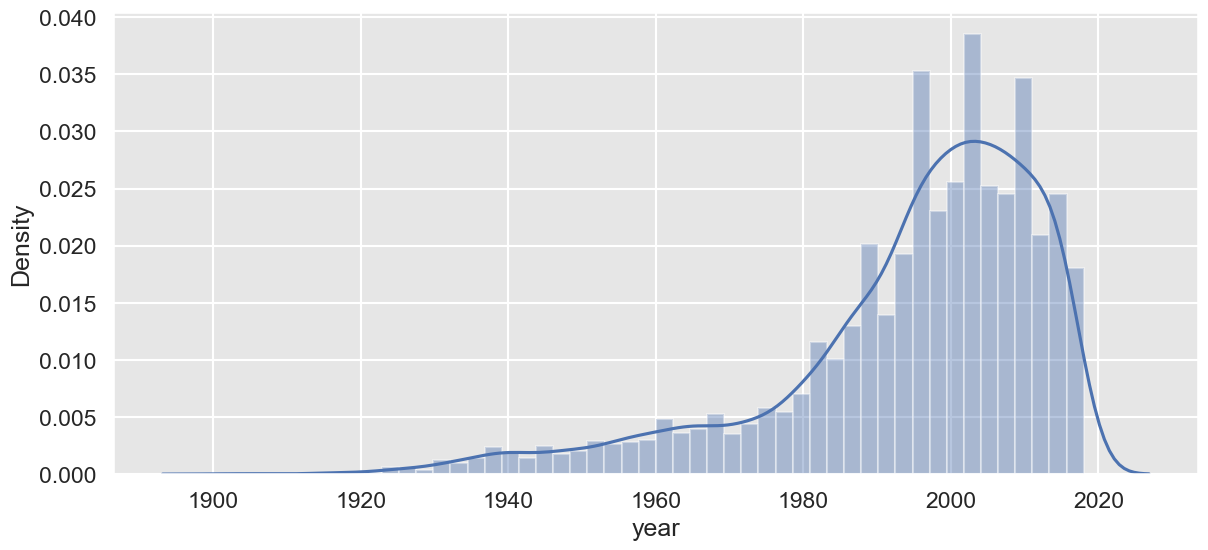

In [41]:
sns.distplot(pandas_df3.year)

/var/folders/24/z61d72zx27z5ml8twybhwmm40000gn/T/ipykernel_1055/3618656554.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pandas_df3)


(1940.0, 2020.0)

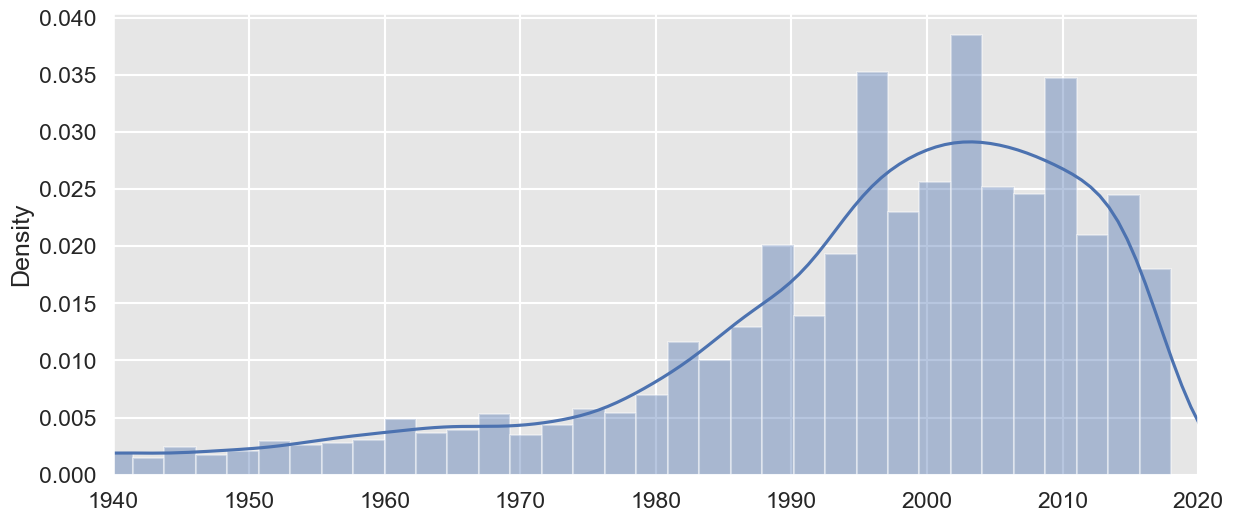

In [43]:
sns.distplot(pandas_df3)
plt.pyplot.xlim(1940,2020)

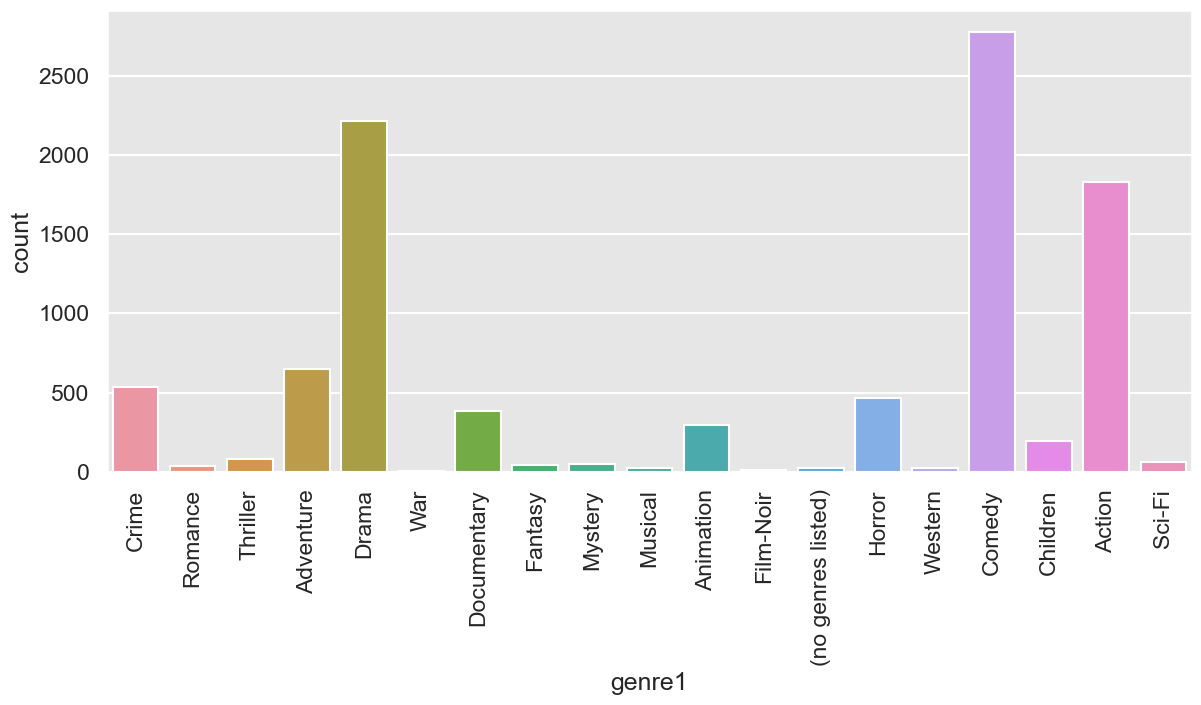

In [47]:
genre = df3.groupBy("genre1").count().toPandas()
sns.barplot(x=genre["genre1"], y=genre["count"])
plt.pyplot.xticks(rotation=90)
plt.pyplot.show()

In [49]:
sample_df1 = df1.select(["userId", "movieId", "rating"]).sample(False, 0.25, 42)
cols = ["movieId", "genre1"]
b1 = df3[cols]
box_genre = sample_df1.join(b1, on="movieId", how="inner").toPandas()

(0.0, 6.0)

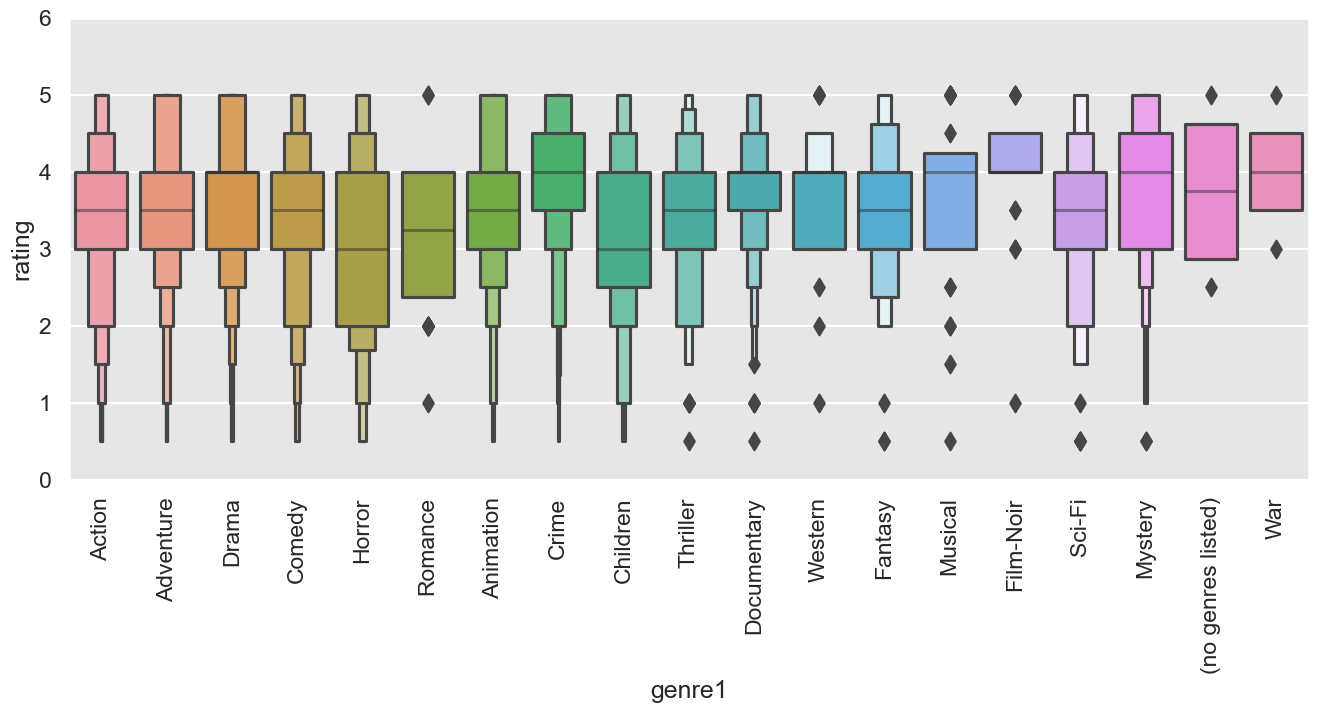

In [50]:
sns.set(rc={"figure.figsize" : (16,6)})
sns.set_context("talk")
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.boxenplot(x=box_genre.genre1, y=box_genre.rating, data=box_genre)
plt.pyplot.xticks(rotation=90)
plt.pyplot.ylim(0,6)

In [51]:
df3.show(3)

+-------+--------------------+----+---------+---------+-------+------+------+------+------+------+------+-------+-----------+-----------------+------------+
|movieId|               title|year|   genre1|   genre2| genre3|genre4|genre5|genre6|genre7|genre8|genre9|genre10|genre_count|       rating_avg|rating_count|
+-------+--------------------+----+---------+---------+-------+------+------+------+------+------+------+-------+-----------+-----------------+------------+
|   1580|Men in Black (a.k...|1997|   Action|   Comedy| Sci-Fi|  NULL|  NULL|  NULL|  NULL|  NULL|  NULL|   NULL|          3|3.487878787878788|         165|
|   2366|    King Kong (1933)|1933|   Action|Adventure|Fantasy|Horror|  NULL|  NULL|  NULL|  NULL|  NULL|   NULL|          4|             3.64|          25|
|   3175| Galaxy Quest (1999)|1999|Adventure|   Comedy| Sci-Fi|  NULL|  NULL|  NULL|  NULL|  NULL|  NULL|   NULL|          3|             3.58|          75|
+-------+--------------------+----+---------+---------+---

### Визуализация ТОП-10 фильмов

In [52]:
top10_movies = df3.orderBy(col("rating_count").desc()).limit(10)
top10_movies = top10_movies.select("movieId", "title")
top10_movies = top10_movies.join(sample_df1, on="movieId", how="inner").toPandas()

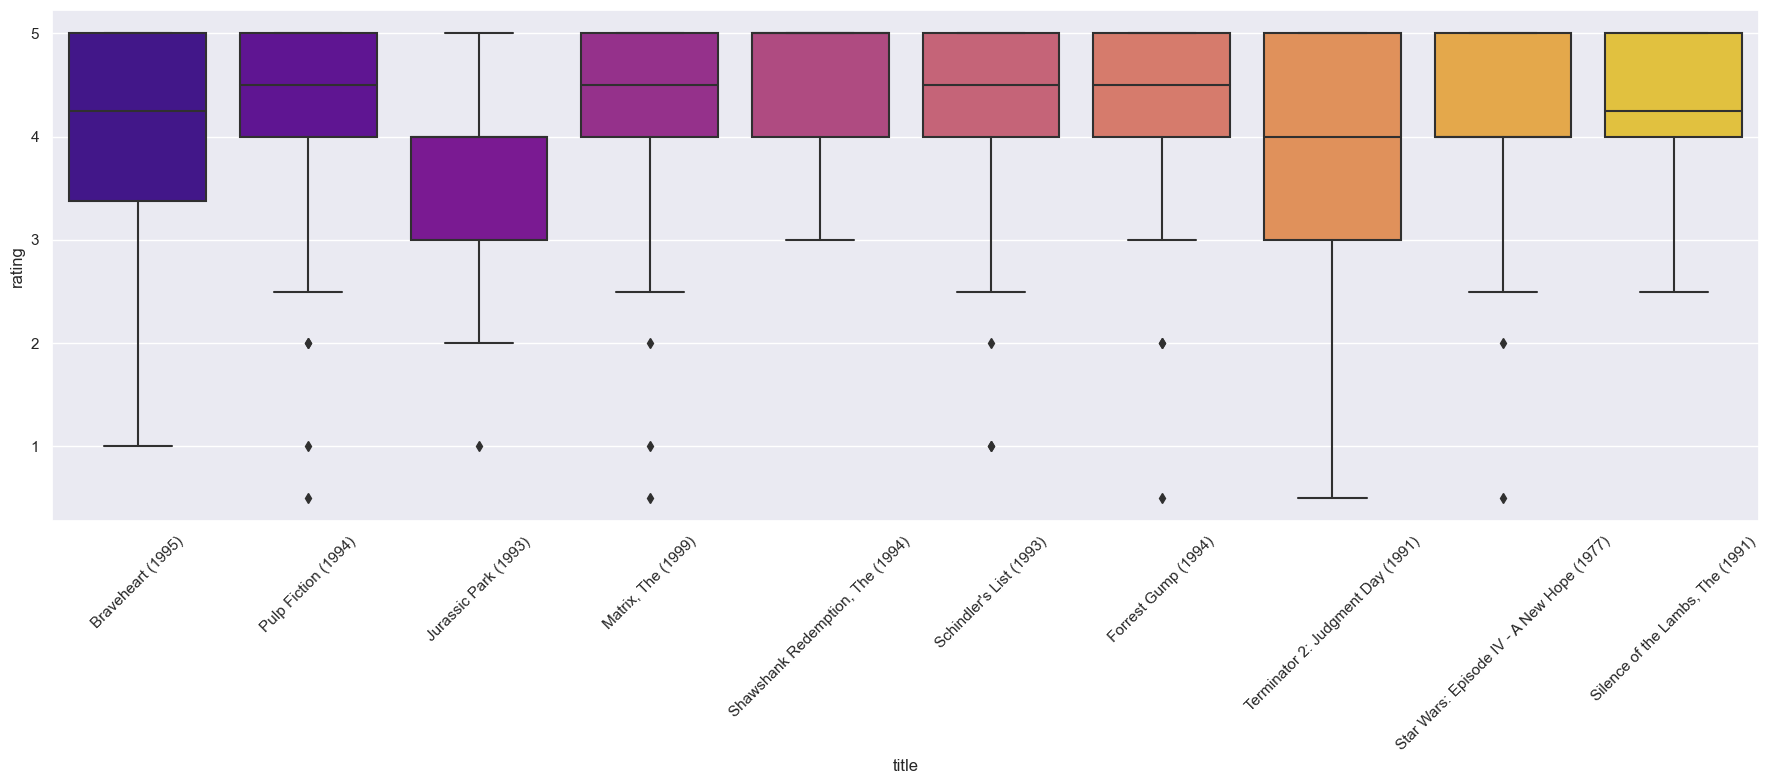

In [54]:
sns.set(rc={'figure.figsize':(18, 8)})
sns.boxplot(x='title', y='rating', data=top10_movies, palette ='plasma')
plt.pyplot.xticks(rotation=45)
plt.pyplot.tight_layout()

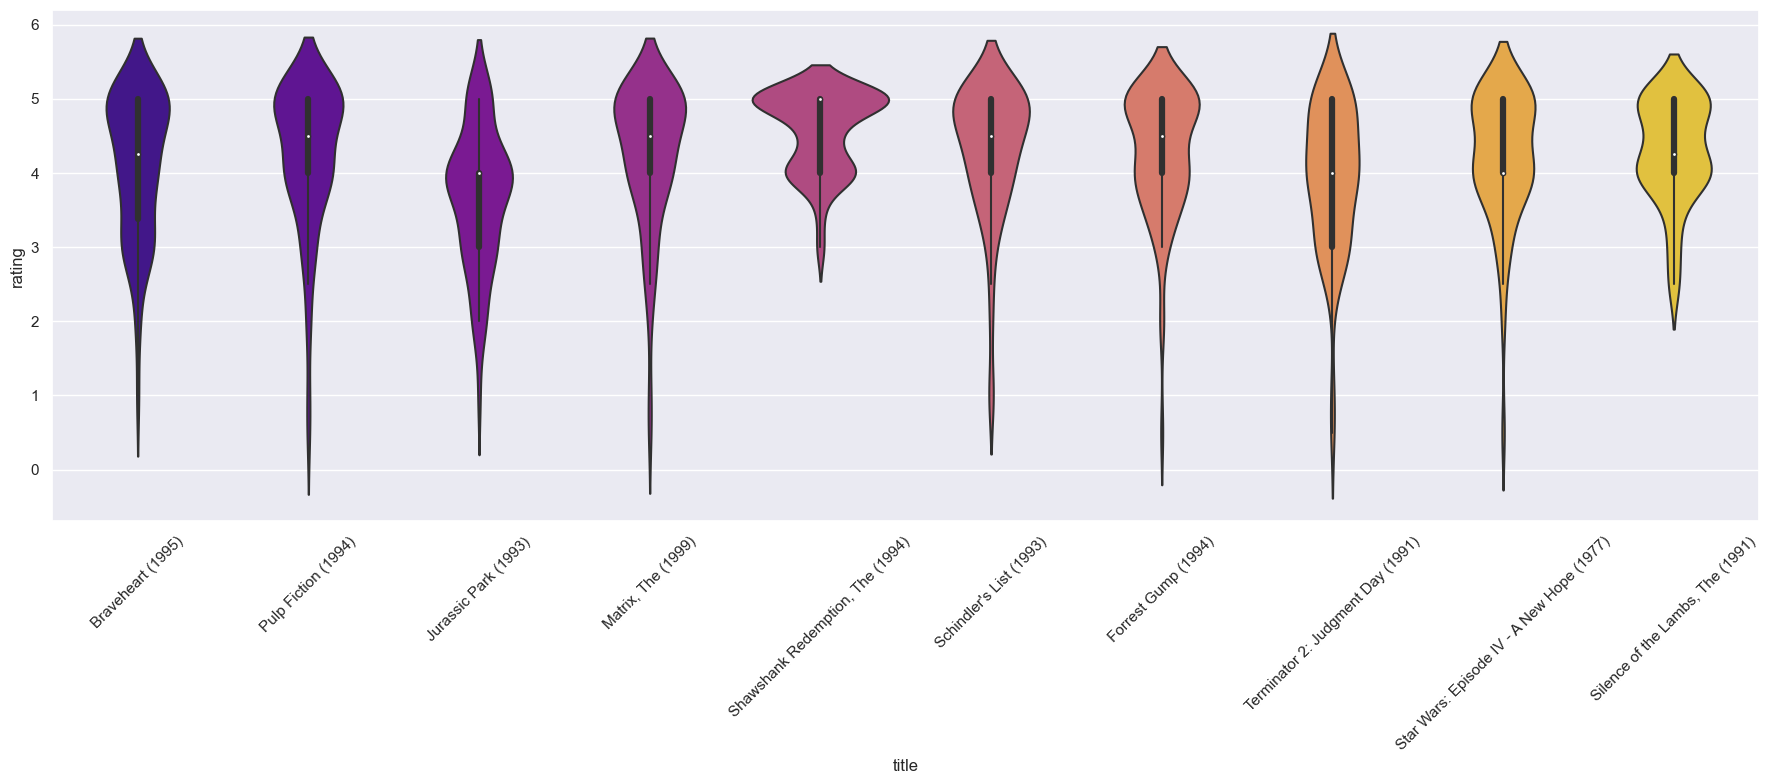

In [55]:
sns.set(rc={'figure.figsize':(18, 8)})
sns.violinplot(x='title', y='rating', data=top10_movies, palette ='plasma')
plt.pyplot.xticks(rotation=45)
plt.pyplot.tight_layout()

In [ ]:
spark.stop()